In [47]:
from requests import get
from bs4 import BeautifulSoup
import os
import re
from env import github_token, github_username
import scraper
import acquire_r
import pandas as pd
import json
import seaborn as sns
import time
import prepare_r
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from wordcloud import WordCloud
import nltk

In [97]:
headers = {"Authorization": f"token {github_token}", "User-Agent": github_username}

if headers["Authorization"] == "token " or headers["User-Agent"] == "":
    raise Exception(
        "You need to follow the instructions marked TODO in this script before trying to use it"
    )

In [94]:
# List of urls to scrape
g_url = ['https://github.com/search?o=desc&p=1&q=stars%3A%3E1&s=forks&type=Repositories', ' https://github.com/search?o=desc&p=2&q=stars%3A%3E1&s=forks&type=Repositories'\
         'https://github.com/search?o=desc&p=3&q=stars%3A%3E1&s=forks&type=Repositories', 'https://github.com/search?o=desc&p=4&q=stars%3A%3E1&s=forks&type=Repositories',\
         'https://github.com/search?o=desc&p=5&q=stars%3A%3E1&s=forks&type=Repositories','https://github.com/search?o=desc&p=6&q=stars%3A%3E1&s=forks&type=Repositories',\
        'https://github.com/search?o=desc&p=7&q=stars%3A%3E1&s=forks&type=Repositories','https://github.com/search?o=desc&p=8&q=stars%3A%3E1&s=forks&type=Repositories',\
        'https://github.com/search?o=desc&p=9&q=stars%3A%3E1&s=forks&type=Repositories','https://github.com/search?o=desc&p=10&q=stars%3A%3E1&s=forks&type=Repositories',\
        'https://github.com/search?o=desc&p=11&q=stars%3A%3E1&s=forks&type=Repositories','https://github.com/search?o=desc&p=12&q=stars%3A%3E1&s=forks&type=Repositories',\
         'https://github.com/search?o=desc&p=13&q=stars%3A%3E1&s=forks&type=Repositories','https://github.com/search?o=desc&p=14&q=stars%3A%3E1&s=forks&type=Repositories',\
        'https://github.com/search?o=desc&p=15&q=stars%3A%3E1&s=forks&type=Repositories','https://github.com/search?o=desc&p=16&q=stars%3A%3E1&s=forks&type=Repositories']

In [98]:
def get_repos(urls):
    repo = []
    for url in urls:
        time.sleep(10)
        response = get(url, headers=headers)
        soup = BeautifulSoup(response.text)
        text = soup.find_all(attrs={"f4 text-normal"})
        for i in text:
            repo.append(i.find('a')['href'])
    return repo

In [99]:
repos = get_repos(g_url)

In [116]:
# list = []
# for repo in repos:
#     list.append(repo[1:])
    

In [92]:
#repos = scraper.get_repos(g_url)

/Users/ravindersingh/codeup-data-science/nlp_project/git-language/scraper.py:28: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 28 of the file /Users/ravindersingh/codeup-data-science/nlp_project/git-language/scraper.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  soup = BeautifulSoup(response.text)


In [122]:
f = open('data1.json')
json_file = json.load(f)

In [127]:
df = pd.DataFrame(json_file)

In [128]:
df

,repo,language,readme_contents
0,jtleek/datasharing,None,How to share data with a statistician\n=======...
1,rdpeng/ProgrammingAssignment2,R,### Introduction\n\nThis second programming as...
2,octocat/Spoon-Knife,HTML,### Well hello there!\n\nThis repository is me...
3,tensorflow/tensorflow,C++,"<div align=""center"">\n <img src=""https://www...."
4,SmartThingsCommunity/SmartThingsPublic,Groovy,# SmartThings Public GitHub Repo\n\nAn officia...
...,...,...,...
144,mdn/learning-area,HTML,# learning-area\nGithub repo for the [MDN Lear...
145,linuxacademy/devops-essentials-sample-app,HTML,# devops-essentials-sample-app\n\nThis is a si...
146,TheAlgorithms/Java,Java,# 알고리즘 - 자바\n\n## 이 [개발브런치](https://github.com...
147,bettiolo/node-echo,JavaScript,"node-echo\n=========\n\nnode.js echo server, r..."


In [129]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             149 non-null    object
 1   language         132 non-null    object
 2   readme_contents  149 non-null    object
dtypes: object(3)
memory usage: 3.6+ KB


In [130]:
df.isnull().sum()

repo                0
language           17
readme_contents     0
dtype: int64

In [131]:
df = df.dropna(axis =0)

In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132 entries, 1 to 148
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             132 non-null    object
 1   language         132 non-null    object
 2   readme_contents  132 non-null    object
dtypes: object(3)
memory usage: 4.1+ KB


In [133]:
df = df.reset_index(drop = True)

In [135]:
df.language.value_counts()

JavaScript          28
Python              19
Java                14
C++                  9
HTML                 8
TypeScript           7
Go                   7
Jupyter Notebook     6
C                    6
CSS                  5
Shell                3
Vue                  3
C#                   2
Ruby                 2
PowerShell           2
PHP                  2
Kotlin               2
Dart                 1
Objective-C          1
ApacheConf           1
Groovy               1
R                    1
Scala                1
Rust                 1
Name: language, dtype: int64

In [136]:
df['language'] = df.language.replace(['PHP','Shell','Kotlin','Vue','ApacheConf','Jupyter Notebook','R','Groovy',\
                                      'Kotlin','Scala','Rust','C#','Dart','Ruby','Objective-C','PowerShell' ], 'Other')

In [137]:
df.language.value_counts()

Other         29
JavaScript    28
Python        19
Java          14
C++            9
HTML           8
Go             7
TypeScript     7
C              6
CSS            5
Name: language, dtype: int64

In [ ]:
df.drop

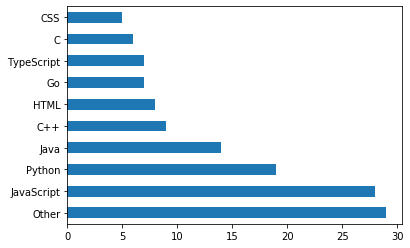

In [138]:
# bar plot showing repo counts by language
df.language.value_counts().plot.barh()

In [139]:
df = df.drop(columns = ['repo'])

In [140]:
df.head(4)

,language,readme_contents
0,Other,### Introduction\n\nThis second programming as...
1,HTML,### Well hello there!\n\nThis repository is me...
2,C++,"<div align=""center"">\n <img src=""https://www...."
3,Other,# SmartThings Public GitHub Repo\n\nAn officia...


In [141]:
y = df.language
X = df.readme_contents
train, test = train_test_split(df, stratify=df.language, test_size=.2, random_state=123)

In [142]:
train

,language,readme_contents
40,Java,<!-- the line below needs to be an empty line ...
4,JavaScript,"<p align=""center"">\n <a href=""https://getboot..."
27,Other,[996.ICU](https://996.icu/#/en_US)\n=======\n*...
50,Go,The Moby Project\n================\n\n![Moby P...
3,Other,# SmartThings Public GitHub Repo\n\nAn officia...
...,...,...
92,Other,# Starter Web Repo\n\nThis repository is for s...
74,C,![Darknet Logo](http://pjreddie.com/media/file...
107,Java,Spring Boot 学习示例\n=========================\n\...
14,Java,"# <img src=""src/docs/spring-framework.png"" wid..."


In [143]:
train1 = train.readme_contents.groupby(train.language).sum()

In [144]:
train1 = pd.DataFrame(train1).reset_index()

In [145]:
train1.head(4)

,language,readme_contents
0,C,# Quantum Mechanical Keyboard Firmware\n\n[![C...
1,C++,# Marlin 3D Printer Firmware\n\n![GitHub](http...
2,CSS,# Travel Destinations\n\nA simple app to keep ...
3,Go,The Moby Project\n================\n\n![Moby P...


In [146]:
train = prepare_r.prep_contents(train)

In [147]:
train = train.drop(columns = ['original', 'normalized', 'stemmed', 'lemmatized'])
train.head(4)

,language,readme_contents,cleaned
40,Java,<!-- the line below needs to be an empty line ...,line need empty line kramdown isnt smart dearl...
4,JavaScript,"<p align=""center"">\n <a href=""https://getboot...",align center href getbootstrap com img src get...
27,Other,[996.ICU](https://996.icu/#/en_US)\n=======\n*...,icu icu please note exists official account ap...
50,Go,The Moby Project\n================\n\n![Moby P...,moby project moby project logo doc static file...


In [148]:
train1 = prepare_r.prep_contents(train1)

In [149]:
train1 = train1.drop(columns = ['original', 'normalized', 'stemmed', 'lemmatized'])


In [150]:
word_counts = pd.Series(" ".join(train.cleaned).split()).value_counts().head(15)
word_counts

com           4716
org           1268
python         794
doc            765
data           706
yes            659
html           583
name           573
learning       545
api            544
javascript     535
library        533
master         525
unknown        525
code           474
dtype: int64

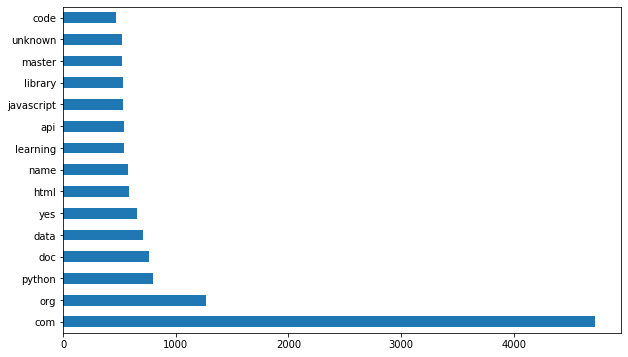

In [151]:
plt.figure(figsize = (10,6))
word_counts.plot.barh()

In [152]:
#IDF function
def idf(word):
    n_occurences = sum([1 for doc in train.cleaned if word in doc])
    return len(train.cleaned) / n_occurences

In [153]:
#Find unique word list from DF cleaned column
unique_words = pd.Series(' '.join(train.cleaned).split()).unique()
unique_words

array(['line', 'need', 'empty', ..., 'operates', 'toy', 'familiarize'],
      dtype=object)

In [154]:
# put the unique words into a data frame
idf_train = pd.DataFrame(dict(word = unique_words))\
.assign(idf = lambda train: train.word.apply(idf))\
.set_index('word').sort_values(by='idf', ascending = False)

In [155]:
idf_train.head(10)

,idf
word,
leonidlebedev,105.0
colorlibhq,105.0
browsersync,105.0
pixeden,105.0
graphicsfuel,105.0
blur,105.0
pickaface,105.0
uifaces,105.0
begun,105.0


Text(0.5, 0, 'IDF value')

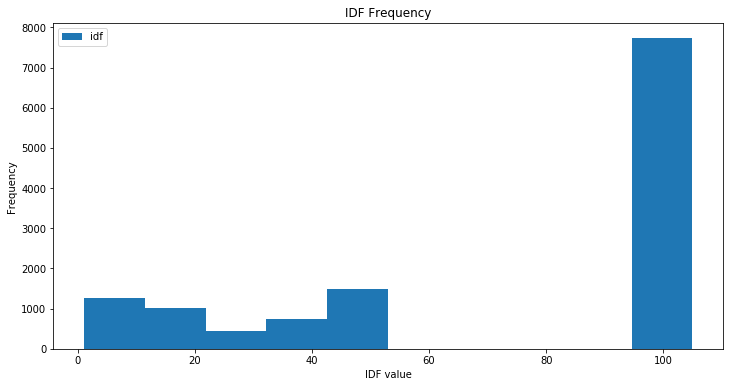

In [156]:
idf_train.plot.hist(figsize=(12,6))
plt.title('IDF Frequency')
plt.xlabel('IDF value')


In [157]:
# here we create a new column with number of words for each readme file.
train['readme_words'] = train['cleaned'].apply(lambda x: len(x.split()))

In [158]:
train

,language,readme_contents,cleaned,readme_words
40,Java,<!-- the line below needs to be an empty line ...,line need empty line kramdown isnt smart dearl...,294
4,JavaScript,"<p align=""center"">\n <a href=""https://getboot...",align center href getbootstrap com img src get...,1155
27,Other,[996.ICU](https://996.icu/#/en_US)\n=======\n*...,icu icu please note exists official account ap...,598
50,Go,The Moby Project\n================\n\n![Moby P...,moby project moby project logo doc static file...,311
3,Other,# SmartThings Public GitHub Repo\n\nAn officia...,smartthings public repo official list smartapp...,51
...,...,...,...,...
92,Other,# Starter Web Repo\n\nThis repository is for s...,starter web repo repository showing git work p...,13
74,C,![Darknet Logo](http://pjreddie.com/media/file...,darknet logo pjreddie com medium file darknet ...,75
107,Java,Spring Boot 学习示例\n=========================\n\...,spring boot spring boot img shield badge sprin...,1068
14,Java,"# <img src=""src/docs/spring-framework.png"" wid...",img src src doc spring framework png width hei...,255


(0, 10000)

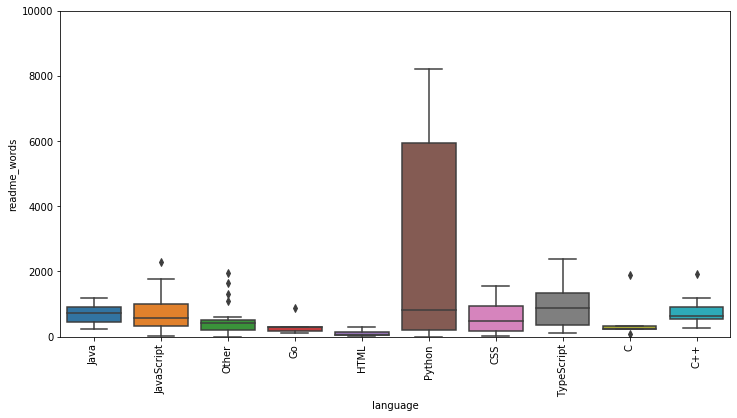

In [159]:
plt.figure(figsize = (12,6))
sns.boxplot(x = 'language', y = 'readme_words', data = train)
plt.xticks(rotation = 90)
plt.ylim(0,10000)

(0, 2000)

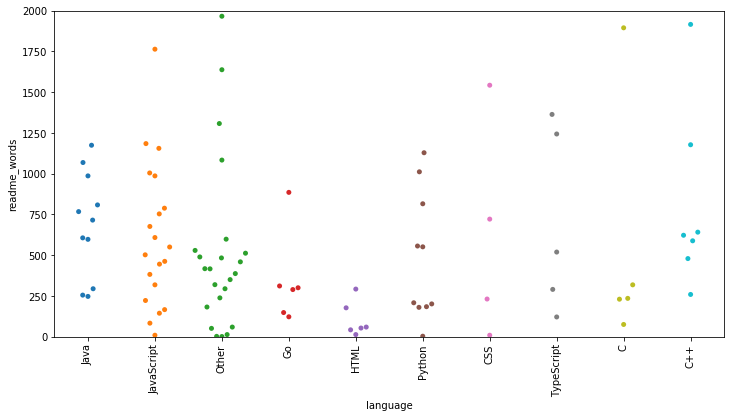

In [178]:
plt.figure(figsize = (12,6))
sns.swarmplot(x = 'language', y = 'readme_words', data = train)
plt.xticks(rotation = 90)
plt.ylim(0,2000)

#### It seems like the median length of readme file is not very different between languages. Python however seems to have much bigger spread

In [179]:
# Next lets explore which words appear most often in a particular language
train.language.value_counts()

Other         23
JavaScript    22
Python        15
Java          11
C++            7
Go             6
TypeScript     6
HTML           6
C              5
CSS            4
Name: language, dtype: int64

In [180]:
All_words = pd.Series(' '.join(train.cleaned).split()).value_counts()
JavaScript_words = pd.Series(' '.join(train[train.language == 'JavaScript'].cleaned).split()).value_counts()
Other_words = pd.Series(' '.join(train[train.language == 'Other'].cleaned).split()).value_counts()
Python_words = pd.Series(' '.join(train[train.language == 'Python'].cleaned).split()).value_counts()
java_words = pd.Series(' '.join(train[train.language == 'Java'].cleaned).split()).value_counts()
TypeScript_words = pd.Series(' '.join(train[train.language == 'TypeScript'].cleaned).split()).value_counts()
Cplus_words = pd.Series(' '.join(train[train.language == 'C++'].cleaned).split()).value_counts()
CSS_words = pd.Series(' '.join(train[train.language == 'CSS'].cleaned).split()).value_counts()
HTML_words = pd.Series(' '.join(train[train.language == 'HTML'].cleaned).split()).value_counts()
C_words = pd.Series(' '.join(train[train.language == 'C'].cleaned).split()).value_counts()
Go_words = pd.Series(' '.join(train[train.language == 'Go'].cleaned).split()).value_counts()

In [181]:
word_counts = (pd.concat([All_words, JavaScript_words, Other_words, Python_words,java_words, TypeScript_words, Cplus_words,\
                         CSS_words,HTML_words, C_words, Go_words],\
                         axis=1, sort=True).set_axis(['All','JavaScript', 'Other', 'Python','Java', 'TypeScript', 'C++',\
                         'CSS','HTML', 'C', 'Go_'], axis=1, inplace=False).fillna(0)\
               .apply(lambda s: s.astype(int)))

word_counts.head()

,All,JavaScript,Other,Python,Java,TypeScript,C++,CSS,HTML,C,Go_
aab,1,0,1,0,0,0,0,0,0,0,0
aac,2,0,0,2,0,0,0,0,0,0,0
aadc,1,0,0,0,1,0,0,0,0,0,0
aaef,1,0,0,0,1,0,0,0,0,0,0
aafb,1,0,0,1,0,0,0,0,0,0,0


In [182]:
word_counts.sort_values(by='All', ascending=False).head(15)

,All,JavaScript,Other,Python,Java,TypeScript,C++,CSS,HTML,C,Go_
com,4716,1026,522,2161,359,242,211,98,16,27,54
org,1268,338,79,522,41,72,162,17,6,8,23
python,794,2,30,732,1,0,27,0,0,2,0
doc,765,169,27,211,214,40,59,15,1,8,21
data,706,70,46,516,33,7,6,1,2,25,0
yes,659,1,0,656,0,1,0,0,0,1,0
html,583,136,17,287,50,21,59,4,1,1,7
name,573,367,12,162,4,13,1,5,1,7,1
learning,545,8,6,495,7,8,17,0,4,0,0
api,544,29,44,426,14,9,17,0,0,4,1


In [183]:
word_counts.sort_values(by='Python', ascending=False).head(15)

,All,JavaScript,Other,Python,Java,TypeScript,C++,CSS,HTML,C,Go_
com,4716,1026,522,2161,359,242,211,98,16,27,54
python,794,2,30,732,1,0,27,0,0,2,0
yes,659,1,0,656,0,1,0,0,0,1,0
unknown,525,0,0,524,0,0,0,1,0,0,0
org,1268,338,79,522,41,72,162,17,6,8,23
data,706,70,46,516,33,7,6,1,2,25,0
learning,545,8,6,495,7,8,17,0,4,0,0
library,533,34,15,458,0,7,12,0,0,5,2
api,544,29,44,426,14,9,17,0,0,4,1
machine,426,5,5,408,0,0,7,1,0,0,0


Text(0.5, 1.0, 'Word cloud for all words')

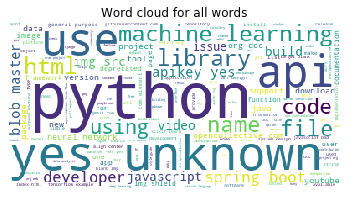

In [184]:
# word cloud for all words
img = WordCloud(background_color='white').generate(' '.join(train.cleaned))
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')
plt.title('Word cloud for all words')

Text(0.5, 1.0, 'Python wordcloud')

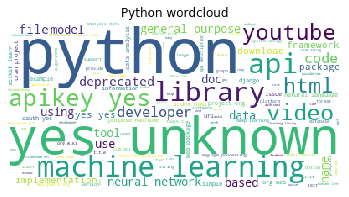

In [185]:
# word cloud for Python
img = WordCloud(background_color='white').generate(' '.join(train[train.language == 'Python'].cleaned))
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.imshow(img)
# axis aren't very useful for a word cloud
plt.axis('off')
plt.title('Python wordcloud')

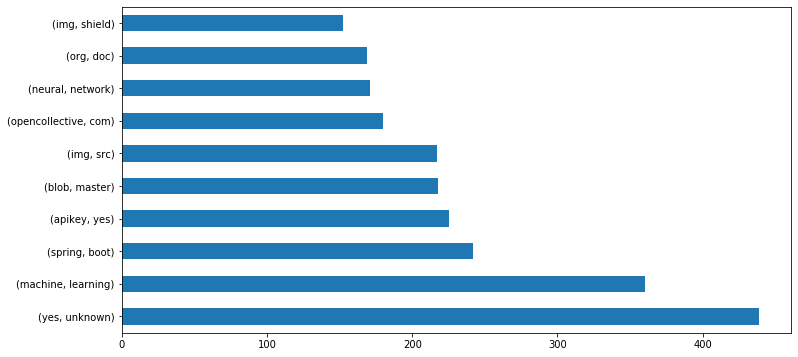

In [186]:
#lets look at bigrams for all text
plt.figure(figsize = (12,6))
bigrams = nltk.ngrams(' '.join(train.cleaned).split(), 2)
pd.Series(bigrams).value_counts().head(10).plot.barh()

In [187]:
top_30_bigrams = pd.Series(nltk.ngrams(' '.join(train.cleaned).split(), 2)).value_counts().head(30)

Text(0.5, 1.0, 'Top 30 Bigrams')

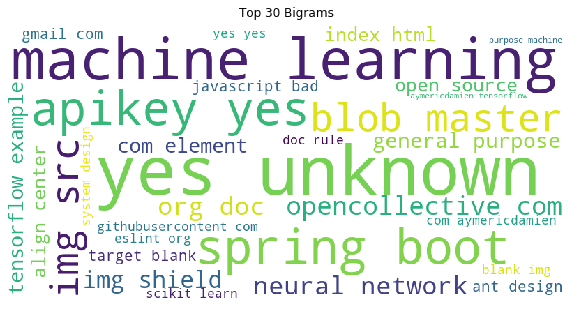

In [188]:
data = {k[0] + ' ' + k[1]: v for k, v in top_30_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.axis('off')
plt.title('Top 30 Bigrams')

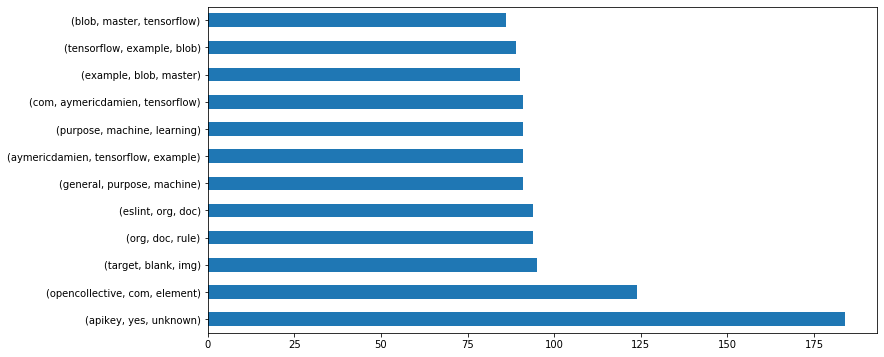

In [189]:
#lets look at trigrams for all text
plt.figure(figsize = (12,6))
bigrams = nltk.ngrams(' '.join(train.cleaned).split(), 3)
pd.Series(bigrams).value_counts().head(12).plot.barh()

In [190]:
top_30_trigrams = pd.Series(nltk.ngrams(' '.join(train.cleaned).split(), 3)).value_counts().head(30)

Text(0.5, 1.0, 'Top 30 Trigrams')

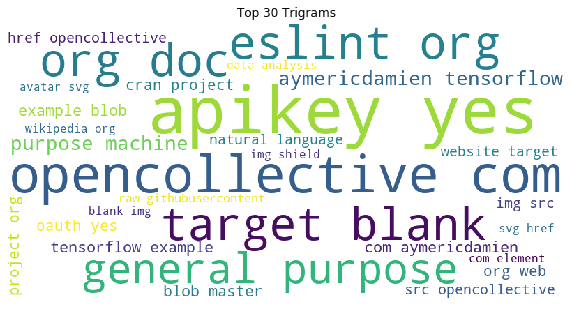

In [191]:
data = {k[0] + ' ' + k[1]: v for k, v in top_30_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.axis('off')
plt.title('Top 30 Trigrams')

In [192]:
def digits(text):
    digits = len(re.sub("[^0-9]", "", text ))
    return digits    

In [193]:
train['digits'] = train.readme_contents.apply(digits)

In [194]:
train

,language,readme_contents,cleaned,readme_words,digits
40,Java,<!-- the line below needs to be an empty line ...,line need empty line kramdown isnt smart dearl...,294,2
4,JavaScript,"<p align=""center"">\n <a href=""https://getboot...",align center href getbootstrap com img src get...,1155,160
27,Other,[996.ICU](https://996.icu/#/en_US)\n=======\n*...,icu icu please note exists official account ap...,598,352
50,Go,The Moby Project\n================\n\n![Moby P...,moby project moby project logo doc static file...,311,2
3,Other,# SmartThings Public GitHub Repo\n\nAn officia...,smartthings public repo official list smartapp...,51,0
...,...,...,...,...,...
92,Other,# Starter Web Repo\n\nThis repository is for s...,starter web repo repository showing git work p...,13,0
74,C,![Darknet Logo](http://pjreddie.com/media/file...,darknet logo pjreddie com medium file darknet ...,75,45
107,Java,Spring Boot 学习示例\n=========================\n\...,spring boot spring boot img shield badge sprin...,1068,315
14,Java,"# <img src=""src/docs/spring-framework.png"" wid...",img src src doc spring framework png width hei...,255,13


(0, 500)

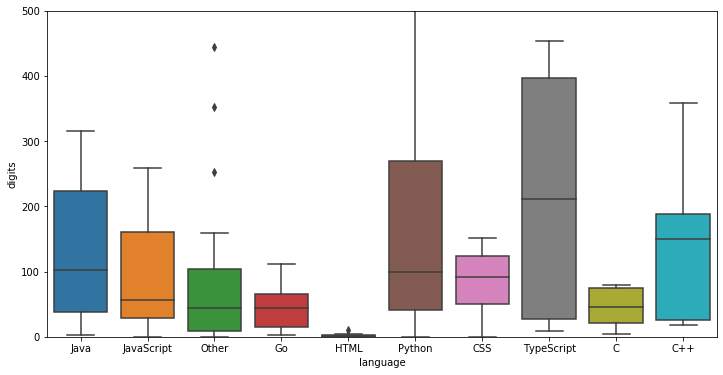

In [195]:
plt.figure(figsize = (12,6))
sns.boxplot(x = 'language', y = 'digits', data = train)
plt.ylim(0,500)